In [1]:
import numpy as np
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import random
import itertools
import time

# Load instance

In [2]:
instance_number = 1  # 0 - "kroA200.tsp"    1 - "kroB200.tsp"
instances_names = ["kroA200.tsp","kroB200.tsp"]
data = np.genfromtxt(f'instances/{instances_names[instance_number]}', skip_header=6, skip_footer=1, dtype='int64')[:,1:]

# Calculating distance matrix

In [3]:
def calc_distance_matrix(data):
    dist_matrix = distance_matrix(data, data)
    dist_matrix = np.around(dist_matrix, decimals=0)
    dist_matrix = dist_matrix.astype(int)
    return dist_matrix

In [4]:
distance_matrix = calc_distance_matrix(data)
distance_matrix

array([[   0, 2607,  549, ..., 1240, 1232, 3117],
       [2607,    0, 3154, ..., 3442, 1644,  933],
       [ 549, 3154,    0, ..., 1097, 1713, 3658],
       ...,
       [1240, 3442, 1097, ...,    0, 2398, 3680],
       [1232, 1644, 1713, ..., 2398,    0, 2406],
       [3117,  933, 3658, ..., 3680, 2406,    0]])

# GREEDY

In [5]:
def random_path(length, dataset_size):
    points = np.arange(dataset_size)
    np.random.shuffle(points)
    path, outside = points[:length], points[length:]
    return path, outside

In [6]:
def knn(k, x, out, distance_matrix):
    tab = []
    pomx = x.tolist()
    for i in range(len(x)):
        sort_neigh = np.argsort(distance_matrix[x[i]])[1:]
        sort_neigh = sort_neigh[~np.in1d(sort_neigh, out)]
        for elem in sort_neigh[:5]:
            j = pomx.index(elem)
            neigh = [i, j]
            neigh.sort()
            if 1 < neigh[1] - neigh[0] < len(x) - 1:
                tab.append(neigh)
    tab = np.array(tab)
    tab = np.unique(tab,axis=0)
    return tab

In [7]:
def path_length(path):
	length = 0
	for i in range(len(path)-1):
		length += distance_matrix[path[i], path[i+1]]

	length += distance_matrix[path[-1], path[0]]
	return length

In [8]:
def delta_change_outside(size, x, out, index, distance_matrix):
    i = index[0]
    j = index[1]
    
    old = distance_matrix[x[(i-1)%size], x[i]] + distance_matrix[x[i], x[(i+1)%size]]
    new = distance_matrix[x[(i-1)%size], out[j]] + distance_matrix[out[j], x[(i+1)%size]]
       
    return old - new

In [9]:
def delta_change_inside_edges(size, x, index, distance_matrix):
    i = index[0]
    j = index[1]
    
    old = distance_matrix[x[(i-1)%size], x[i]] + distance_matrix[x[j], x[(j+1)%size]]
    new = distance_matrix[x[(i-1)%size], x[j]] + distance_matrix[x[i], x[(j+1)%size]]
    
    return old - new

In [10]:
def swap_vertices_outside(x):
    idx = []
    for i in range(len(x)):
        for j in range(len(x)):
            idx.append([i, j])
        
    idx = np.array(idx)
    return idx

In [11]:
def steepest_edge_candidate(size, start, out):
    x = start
    
    # wyznaczenie sąsiedztwa
    N_in = knn(5, x, out, distance_matrix)  
    N_out = swap_vertices_outside(x)
    
    while True:
        # wybór najlepszego ruchu zamiany dwóch wierzchołków 
        max_diff_o = 0
        idx_o = 0
        for id in range(len(N_out)):
            idx = N_out[id]
            diff = delta_change_outside(size, x, out, idx, distance_matrix)
            if diff > max_diff_o:
                max_diff_o = diff
                idx_o = idx
                
        #wybór najlepszego ruchu zamiany dówch krawędzi 
        max_diff_i = 0
        idx_i = 0
        for id in range(len(N_in)):
            idx = [N_in[id][0], (N_in[id][1]-1)%size]
            diff = delta_change_inside_edges(size, x, idx, distance_matrix)
            if diff > max_diff_i:
                max_diff_i = diff
                idx_i = idx
                
            idx = [(N_in[id][0]+1)%size, N_in[id][1]]
            diff = delta_change_inside_edges(size, x, idx, distance_matrix)
            if diff > max_diff_i:
                max_diff_i = diff
                idx_i = idx
            
                
        if (max_diff_i > 0) or (max_diff_o > 0):        
            # ruch zmieniający zbiór wierzchołków 
            if max_diff_o > max_diff_i:
                ver1 = x[idx_o[0]]
                ver2 = out[idx_o[1]]
                x[idx_o[0]] = ver2
                out[idx_o[1]] = ver1  
                N_in = knn(5, x, out, distance_matrix) 
                N_out = swap_vertices_outside(x)

            #ruch wewnątrztrasowy zamiana krawędzi
            else:
                a = x[idx_i[0]:idx_i[1]+1]
                a = np.flip(a)
                x[idx_i[0]:idx_i[1]+1] = a
                N_in = knn(5, x, out, distance_matrix) 
                N_out = swap_vertices_outside(x)
        else:
            break
            
    return x

In [ ]:
MIN = 1000000
MAX = 0
SUM = 0
T_MIN = 1000000
T_MAX = 0
T_SUM = 0

for i in range(100):
    if i%5 == 0:
        print(i)
    x, out = random_path(100, 200)
    start = time.time()
    x = steepest_edge_candidate(100, x, out)
    t = time.time() - start
    len_x = path_length(x)
    
    if len_x > MAX:
        MAX = len_x
    if len_x < MIN:
        MIN = len_x
        T = x
    SUM += len_x
    
    if t > T_MAX:
        T_MAX = t
    if t < T_MIN:
        T_MIN = t
    T_SUM += t

In [13]:
print(MIN)
print(MAX)
print(SUM/100)

15528
18793
17204.21


In [14]:
#time
print(T_MIN)
print(T_MAX)
print(T_SUM/100)

12.065017461776733
16.93482518196106
14.191400835514068


In [15]:
def print_plot(data, points):
    f = plt.figure()
    plt.plot(data[:, 0], data[:, 1], "o", linewidth=0, alpha=0.4)
    plt.plot(data[points, 0], data[points, 1], "o", color='tab:blue',  linewidth=0, alpha=0.6)
    plt.plot(data[points, 0], data[points, 1], "--", color="tab:cyan", linewidth=1, alpha=2)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Ruchy kandydackie - kroB200")
    plt.grid(False)
    
    plt.show()
    f.savefig('candidateB.pdf', bbox_inches='tight')

In [16]:
T = np.append(T, T[0])
T

array([157,   2,  10,  92, 121,  72,  52, 169, 148,  69,  38,  39, 189,
       110,  48,  85, 137, 165, 151,  37,  19,  79,  29,  74, 126, 123,
        64, 187,  78, 178,  46,  87, 170, 103, 152,  23,  17,  44,  35,
        16, 191,  77, 186, 125,  12, 154,   1, 108,  41, 119,  13, 124,
        15, 104,  76, 102, 182, 139, 105, 158,  49, 184,  88,  86, 113,
       167, 198, 130, 177,  73, 164,  59, 185,   6,  83,  57,  51, 162,
        53, 114, 168,  24,   8, 160,  11, 173,   0,  94,  97,  31, 166,
       174,  58, 135,  28,   7,  98,  90, 128,  27, 157])

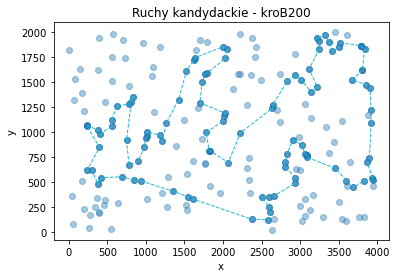

In [17]:
print_plot(data, T)

Zwykły steepest - dla porównania

In [18]:
def swap_edges(x):
    combinations = itertools.combinations(np.arange(len(x)), 2)
    return np.array([[v1,v2] for v1, v2 in combinations if 1 < v2 - v1 < len(x) - 1 ], 'int')

In [19]:
def steepest_edge(size, start, out):
    x = start
    N_in = swap_edges(x)
    N_out = swap_vertices_outside(x)
    while True:
        max_diff_o = 0
        idx_o = 0
        for id in range(len(N_out)):
            idx = N_out[id]
            diff = delta_change_outside(size, x, out, idx, distance_matrix)
            if diff > max_diff_o:
                max_diff_o = diff
                idx_o = idx
        max_diff_i = 0
        idx_i = 0
        for id in range(len(N_in)):
            idx = N_in[id]
            diff = delta_change_inside_edges(size, x, idx, distance_matrix)
            if diff > max_diff_i:
                max_diff_i = diff
                idx_i = idx
                
        if (max_diff_i > 0) or (max_diff_o > 0):        
            # ruch zmieniający zbiór wierzchołków 
            if max_diff_o > max_diff_i:
                ver1 = x[idx_o[0]]
                ver2 = out[idx_o[1]]
                x[idx_o[0]] = ver2
                out[idx_o[1]] = ver1                
                N_in = swap_edges(x)
                N_out = swap_vertices_outside(x)

            #ruch wewnątrztrasowy zamiana krawędzi
            else:
                a = x[idx_i[0]:idx_i[1]+1]
                a = np.flip(a)
                x[idx_i[0]:idx_i[1]+1] = a
                N_in = swap_edges(x)
                N_out = swap_vertices_outside(x)
        else:
            break
            
    return x

In [ ]:
MIN = 100000
MAX = 0
SUM = 0
T_MIN = 100000
T_MAX = 0
T_SUM = 0

for i in range(100):
    print(i)
    x, out = random_path(100, 200)
    start = time.time()
    x = steepest_edge(100, x, out)
    t = time.time() - start
    len_x = path_length(x)
    
    if len_x > MAX:
        MAX = len_x
    if len_x < MIN:
        MIN = len_x
        T = x
    SUM += len_x
    
    if t > T_MAX:
        T_MAX = t
    if t < T_MIN:
        T_MIN = t
    T_SUM += t

In [21]:
print(MIN)
print(MAX)
print(SUM/100)
#time
print(T_MIN)
print(T_MAX)
print(T_SUM/100)

15920
19339
17321.31
14.472309350967407
19.466919660568237
16.652854590415956


In [22]:
def print_plot(data, points):
    f = plt.figure()
    plt.plot(data[:, 0], data[:, 1], "o", linewidth=0, alpha=0.4)
    plt.plot(data[points, 0], data[points, 1], "o", color='tab:blue',  linewidth=0, alpha=0.6)
    plt.plot(data[points, 0], data[points, 1], "--", color="tab:cyan", linewidth=1, alpha=2)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Steepest - kroB200")
    plt.grid(False)
    
    plt.show()
    f.savefig('steepestB.pdf', bbox_inches='tight')

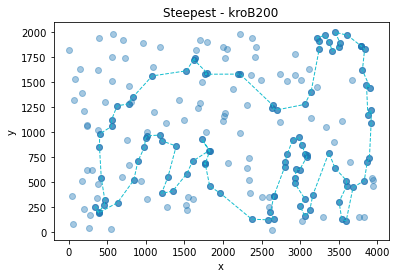

In [23]:
T = np.append(T, T[0])
T
print_plot(data, T)